In [80]:
import random
import matplotlib.pyplot as plt
import numpy as np
import time

N_CITIES = 48  # DNA數(TSP節點數)

POP_SIZE = 50 # 子代數 (population size)
CROSSOVER_RATE = 0.95
MUTATE_RATE = 0.01
GENERATION_GAP = 1.0
# SCALING_WINDOW = 1
# SELECTION_STRAGEGY = 'E' # E or P
N_GENERATIONS = 15000 # 演化代數
ADJUST_FITNESS = 320000

class GA(object):
    def __init__(self, DNA_size, cross_rate, mutation_rate, pop_size, generation_gap=1.0):
        self.DNA_size = DNA_size
        self.cross_rate = cross_rate
        self.mutate_rate = mutation_rate
        self.pop_size = pop_size
        self.generation_gap = generation_gap

        self.pop = np.vstack([np.random.permutation(DNA_size) for _ in range(pop_size)])

    def translateDNA(self, city_position): 
        # 取得下一代
        # lx 為下一代的 x 座標清單
        # ly 為下一代的 y 座標清單
        line_x = np.empty_like(self.pop, dtype=np.float64)
        line_y = np.empty_like(self.pop, dtype=np.float64)
        for i, d in enumerate(self.pop):
            city_coord = city_position[d]
            line_x[i, :] = city_coord[:, 0]
            line_y[i, :] = city_coord[:, 1]
        return line_x, line_y
    
    def calculate_fitness(self, total_distance):
        # 每個子代的適性程度
        fitness = np.exp(ADJUST_FITNESS / total_distance)
        return fitness

    def get_total_distance(self, line_x, line_y):
        # 計算每個子代的分數(距離)
        total_distance = np.empty((line_x.shape[0],), dtype=np.float64)
        for i, (xs, ys) in enumerate(zip(line_x, line_y)): # 算距離
            total_distance[i] = np.sum(np.sqrt(np.square(np.diff(xs)) + np.square(np.diff(ys))))
        return total_distance

    def select(self, fitness, size):
        # 挑選，適性程度越高越容易挑選到，數量 = size
        idx_list = np.random.choice(np.arange(self.pop_size), size=size, replace=True, p=fitness / fitness.sum())
        return self.pop[idx_list], idx_list

    def crossover(self, fitness):
        children = []
        pop_copy = self.pop.copy()
        
        # gap，預計 crossover 幾隻
        childNum = round(self.generation_gap * self.pop_size)
        for i in range(0, int(childNum / 2)):
            # 判斷是否要 crossover
            parent1 = self.select(fitness, 1)[0][0]
            parent2 = self.select(fitness, 1)[0][0]
            if np.random.rand() < self.cross_rate: 
                #print("P1", parent1)
                #print("P2", parent2)
                cross_fragment = sorted(random.choices(list(range(0, self.DNA_size + 1)), k=2))
                parent1_cross_fragment = parent1[cross_fragment[0]:cross_fragment[1]]
                parent2_cross_fragment = parent2[cross_fragment[0]:cross_fragment[1]]
                
                #np.random.shuffle(parent1_cross_fragment)
                #np.random.shuffle(parent2_cross_fragment)                                       
                #print("FR", parent1_cross_fragment)
                #print("FR", parent2_cross_fragment)
                
                parent1_switch_value = []
                parent2_switch_value = []
                for i, (pid1, pid2) in enumerate(zip(parent1_cross_fragment, parent2_cross_fragment)):
                    if not pid1 in parent2_cross_fragment:
                        parent1_switch_value.append(pid1)
                    if not pid2 in parent1_cross_fragment:
                        parent2_switch_value.append(pid2)
                
                parent1_switch_table = {}
                parent2_switch_table = {}
                for i, (pid1, pid2) in enumerate(zip(parent1_switch_value, parent2_switch_value)):
                    parent1_switch_table[pid1] = pid2
                    parent2_switch_table[pid2] = pid1
                 
                parent1_cross = []
                for j in parent1:
                    if j in parent2_switch_table:
                        parent1_cross.append(parent2_switch_table[j])
                    else:
                        parent1_cross.append(j)
                parent1_cross[cross_fragment[0]:cross_fragment[1]] = parent2_cross_fragment
                        
                parent2_cross = []
                for j in parent2:
                    if j in parent1_switch_table:
                        parent2_cross.append(parent1_switch_table[j])
                    else:
                        parent2_cross.append(j)
                parent2_cross[cross_fragment[0]:cross_fragment[1]] = parent1_cross_fragment
                #print("P1", np.array(parent1_cross))
                #print("P2", np.array(parent2_cross))
                #print(len(set(parent1_cross)) == self.DNA_size)
                
                children.append(parent1_cross)

                children.append(parent2_cross)
            else:
                children.append(parent1)
                children.append(parent2)
        
        # 剩下的用隨機
        if self.generation_gap < 1.0:
            children += list(np.vstack([np.random.permutation(self.DNA_size) for _ in range(self.pop_size - childNum)]))
        
        return np.array(children)

    def mutate(self, children):
        children2 = []
        for child in children:
            for point in range(self.DNA_size):
                if np.random.rand() < self.mutate_rate: # 判斷是否要 mutate
                    swap_point = np.random.randint(0, self.DNA_size)
                    swapA, swapB = child[point], child[swap_point]
                    child[point], child[swap_point] = swapB, swapA
            children2.append(child)
        return np.array(children2)

    def evolve(self, fitness):
        children = self.crossover(fitness)
        children = self.mutate(children)
        self.pop = children


class TravelSalesPerson(object):
    def __init__(self, n_cities):
        self.city_position = [
            [6734,1453],
            [2233,10],
            [5530,1424],
            [401,841],
            [3082,1644],
            [7608,4458],
            [7573,3716],
            [7265, 1268],
            [6898, 1885],
            [1112, 2049],
            [5468, 2606],
            [5989, 2873],
            [4706, 2674],
            [4612, 2035],
            [6347, 2683],
            [6107, 669],
            [7611, 5184],
            [7462, 3590],
            [7732, 4723],
            [5900, 3561],
            [4483, 3369],
            [6101, 1110],
            [5199, 2182],
            [1633, 2809],
            [4307, 2322],
            [675, 1006],
            [7555, 4819],
            [7541, 3981],
            [3177, 756],
            [7352, 4506],
            [7545, 2801],
            [3245, 3305],
            [6426, 3173],
            [4608, 1198],
            [23, 2216],
            [7248, 3779],
            [7762, 4595],
            [7392, 2244],
            [3484, 2829],
            [6271, 2135],
            [4985, 140],
            [1916, 1569],
            [7280, 4899],
            [7509, 3239],
            [10, 2676],
            [6807, 2993],
            [5185, 3258],
            [3023, 1942]
        ] #np.random.rand(n_cities, 2) # 創立 TSP 環境，隨機 n_cities 個節點
        self.city_position = np.array(self.city_position)
        plt.ion()

    def plotting(self, lx, ly, total_d):
        # 畫圖
        plt.cla()
        plt.scatter(self.city_position[:, 0].T, self.city_position[:, 1].T, s=100, c='k')
        plt.plot(lx.T, ly.T, 'r-')
        plt.text(-0.05, -0.05, "Total distance=%.2f" % total_d, fontdict={'size': 20, 'color': 'red'})
        plt.xlim((-1000, 9000))
        plt.ylim((-1000, 6000))
        plt.pause(0.01)

世代: 1000 | best distance: 106578.8964003597 | 最佳適應值 20.14 29
世代: 2000 | best distance: 107043.13540325686 | 最佳適應值 19.87 1
世代: 3000 | best distance: 117638.31832520507 | 最佳適應值 15.18 44
世代: 4000 | best distance: 43402.9979602365 | 最佳適應值 1592.03 23
世代: 5000 | best distance: 40428.04794038655 | 最佳適應值 2738.86 3
世代: 6000 | best distance: 39500.63762270911 | 最佳適應值 3298.21 0
世代: 7000 | best distance: 39733.82479071882 | 最佳適應值 3145.07 20
世代: 8000 | best distance: 38088.805327144946 | 最佳適應值 4453.38 5
世代: 9000 | best distance: 37704.6042564015 | 最佳適應值 4851.42 9
世代: 10000 | best distance: 37599.69264870096 | 最佳適應值 4967.68 4
世代: 11000 | best distance: 37751.62335249348 | 最佳適應值 4800.41 28
世代: 12000 | best distance: 37406.42620168579 | 最佳適應值 5190.99 40
世代: 13000 | best distance: 37453.58165636456 | 最佳適應值 5135.38 0
世代: 14000 | best distance: 37899.359587960396 | 最佳適應值 4644.39 2
世代: 15000 | best distance: 37899.180738638504 | 最佳適應值 4644.57 0
best distance: 37121.3761854748
CPU Time 130.0365390777588
平均

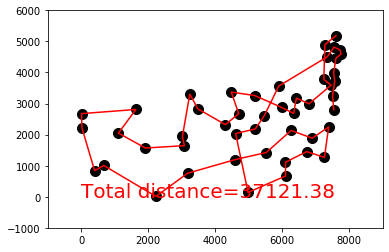

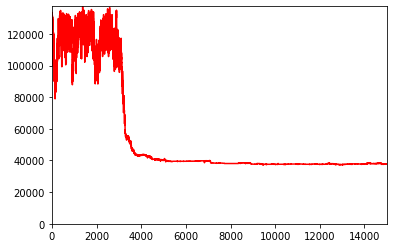

In [87]:
ALL_LOSS = []
     
start_time = time.time()
for i in range(0, 1):
    ALL_DISTANCE = []
    ALL_GENERATION = []
    ALL_lx = []
    ALL_ly = []
    
    ga = GA(DNA_size=N_CITIES, pop_size=POP_SIZE, cross_rate=CROSSOVER_RATE, mutation_rate=MUTATE_RATE, generation_gap=GENERATION_GAP) # GA 物件
    env = TravelSalesPerson(N_CITIES) # 創立 TSP 環境
    for generation in range(1, N_GENERATIONS + 1):
        lx, ly = ga.translateDNA(env.city_position) # 取得下一代組合
        total_distance = ga.get_total_distance(lx, ly) # 算每一子代的分數(TSP 距離)
        fitness = ga.calculate_fitness(total_distance) # 算每一子代的環境適性程度
        ga.evolve(fitness) # 演化下一代組合
        best_idx = np.argmax(fitness) # 取得當代適應程度最好的一組 index
        
        ALL_DISTANCE.append(total_distance[best_idx])
        ALL_lx.append(lx[best_idx])
        ALL_ly.append(ly[best_idx])
        ALL_GENERATION.append(generation)
        
        # 畫當代最佳解
        if generation % 1000 == 0:
            print('世代:', generation,'| best distance:', total_distance[best_idx], '| 最佳適應值 %.2f' % fitness[best_idx], best_idx)
#             env.plotting(lx[best_idx], ly[best_idx], total_distance[best_idx])
         
        if generation == N_GENERATIONS:
            exec_time =  time.time() - start_time
            loss = (total_distance[best_idx] - 33523) / 33523
            ALL_LOSS.append(loss)
            print('best distance:',  min(ALL_DISTANCE))
            print('CPU Time', exec_time)
            print("平均誤差: %.2f" % (sum(ALL_LOSS) / len(ALL_LOSS),) + '%')
            
            #print('世代:', generation,'| best distance:', total_distance[best_idx], '| 最佳適應值 %.2f' % fitness[best_idx], best_idx)
            env.plotting(ALL_lx[ALL_DISTANCE.index(min(ALL_DISTANCE))], ALL_ly[ALL_DISTANCE.index(min(ALL_DISTANCE))], min(ALL_DISTANCE))
            
            
            
            plt.cla()
            plt.plot(ALL_GENERATION, ALL_DISTANCE, 'r-')
            plt.xlim((0, N_GENERATIONS))
            plt.ylim((0, max(ALL_DISTANCE)))
            plt.pause(0.01)
            
    


plt.ioff()
plt.show()